In [66]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

warnings.filterwarnings("ignore")

In [19]:
# Read the csv and feed it into the variable xc
xc = pd.read_csv("morg-2014-emp.csv")

In [40]:
# Filter dataset for healthcare practitioners
xc = xc.loc[((xc["occ2012"] >= 3000) & (xc["occ2012"] <= 3540))]

In [21]:
# Calculating average earnings for each gender
average_earnings_men = xc[xc['sex'] == 1]['earnwke'].mean()
average_earnings_women = xc[xc['sex'] == 2]['earnwke'].mean()

# Calculating the wage gap
wage_gap = average_earnings_men - average_earnings_women
wage_gap_percentage = (wage_gap / average_earnings_men) * 100

# Printing the results
print(f"Average Earnings for Men: ${average_earnings_men:.2f}")
print(f"Average Earnings for Women: ${average_earnings_women:.2f}")
print(f"Unconditional Gender Wage Gap: ${wage_gap:.2f}")
print(f"Gender Wage Gap as a Percentage of Men's Earnings: {wage_gap_percentage:.2f}%")

Average Earnings for Men: $1418.55
Average Earnings for Women: $1043.14
Unconditional Gender Wage Gap: $375.41
Gender Wage Gap as a Percentage of Men's Earnings: 26.46%


In [22]:
# number of observations being analzed
len(xc)

9208

In [23]:
xc.columns

Index(['Unnamed: 0', 'hhid', 'intmonth', 'stfips', 'weight', 'earnwke',
       'uhours', 'grade92', 'race', 'ethnic', 'age', 'sex', 'marital',
       'ownchild', 'chldpres', 'prcitshp', 'state', 'ind02', 'occ2012',
       'class', 'unionmme', 'unioncov', 'lfsr94'],
      dtype='object')

In [24]:
import pandas as pd

# Assuming xc is your DataFrame
# Grouping data by sex and education level and calculating mean earnings
grouped_data = xc.groupby(['sex', 'grade92'])['earnwke'].mean().reset_index()

# Pivoting the data for easier calculation and comparison
pivot_data = grouped_data.pivot(index='grade92', columns='sex', values='earnwke')

# Calculating the wage gap (assuming 1 is men and 2 is women)
pivot_data['wage_gap'] = pivot_data[1] - pivot_data[2]
pivot_data['wage_gap_percentage'] = (pivot_data['wage_gap'] / pivot_data[1]) * 100

# Displaying the result
print(pivot_data)


sex                1            2     wage_gap  wage_gap_percentage
grade92                                                            
31        240.000000   423.000000  -183.000000           -76.250000
32        594.000000   373.100000   220.900000            37.188552
33       2884.610000   320.000000  2564.610000            88.906646
34        423.070000   647.600000  -224.530000           -53.071596
35               NaN   406.500000          NaN                  NaN
36               NaN   355.200000          NaN                  NaN
37        780.000000   549.466667   230.533333            29.555556
38        566.160000   467.365000    98.795000            17.450014
39        776.955140   723.176912    53.778228             6.921664
40        859.662419   722.144846   137.517574            15.996695
41        971.455664   864.998489   106.457176            10.958521
42       1048.122909   895.151996   152.970913            14.594749
43       1287.585464  1110.934174   176.651290  

In [25]:
xc["female"] = (xc["sex"] == 2)
xc["w"] = xc["earnwke"] / xc["uhours"]
xc["lnw"] = np.log(xc["w"])

In [32]:
print(xc[['female', 'grade92', 'w']].dtypes)

female        bool
grade92      int64
w          float64
dtype: object


In [33]:
xc['female'] = pd.to_numeric(xc['female'], errors='coerce')
xc['grade92'] = pd.to_numeric(xc['grade92'], errors='coerce')
xc['w'] = pd.to_numeric(xc['w'], errors='coerce')

In [34]:
xc = xc.dropna(subset=['female', 'grade92', 'w'])

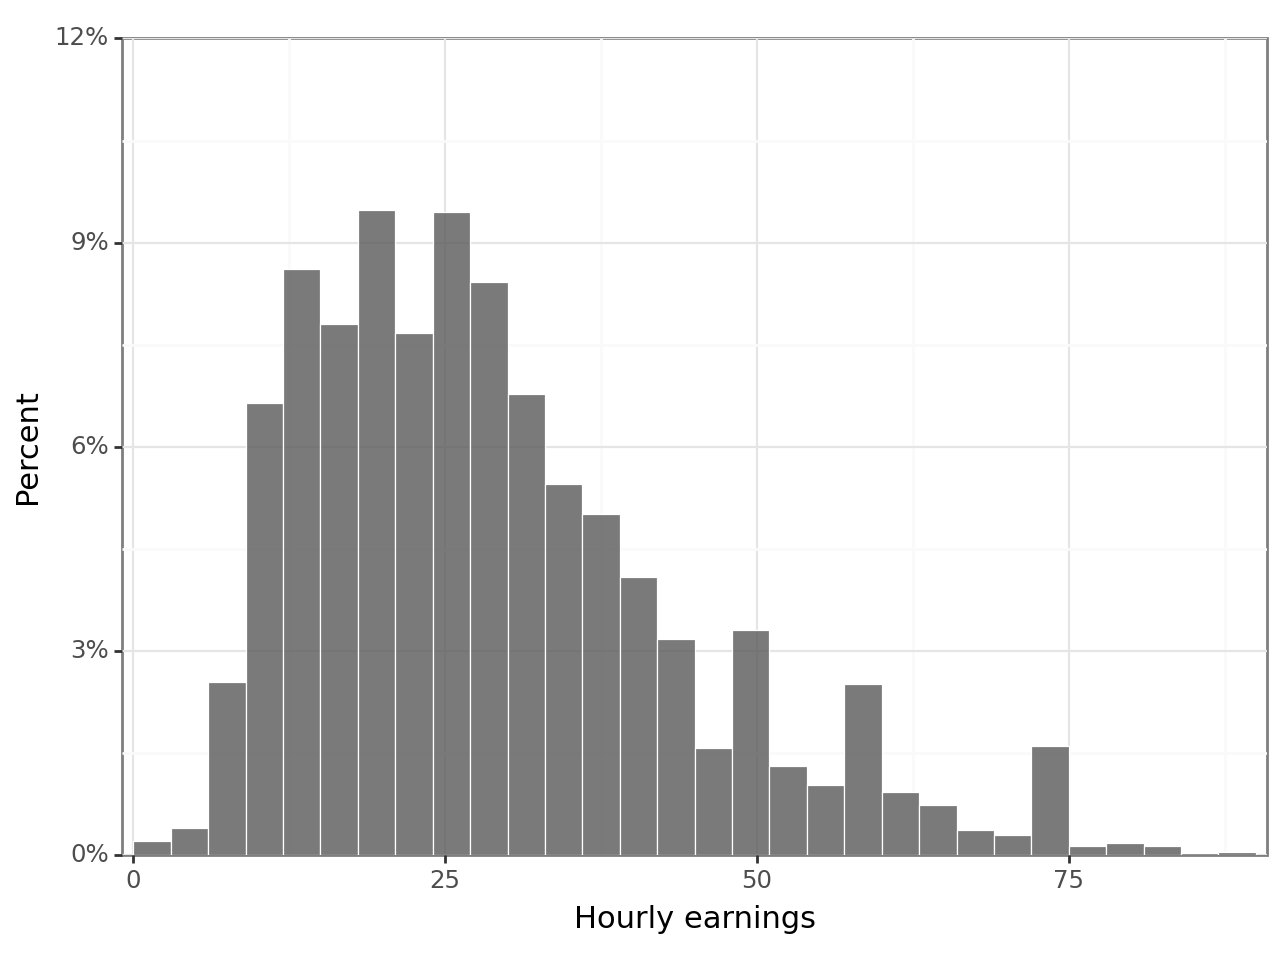

<Figure Size: (640 x 480)>

In [47]:

(
    ggplot(xc, aes(x="w", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=3,
        boundary=0,
        color="white",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Hourly earnings", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 90))
    + scale_y_continuous(
        labels=percent_format(), #mizani
        limits=(0, 0.12),
        expand=(0.0, 0.0),
    )
    + theme_bw()
)


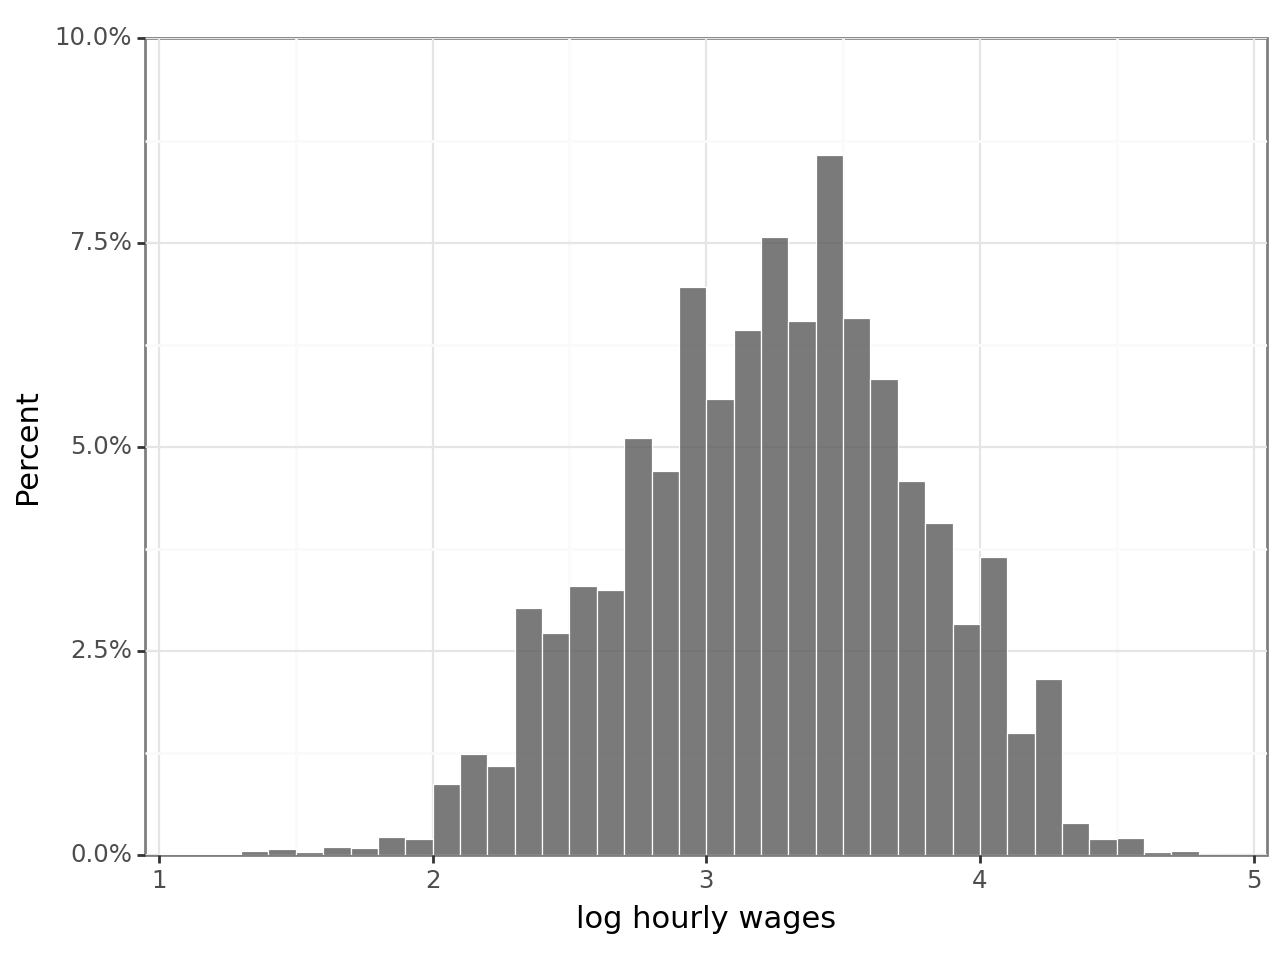

<Figure Size: (640 x 480)>

In [49]:
(
    ggplot(xc, aes(x="lnw", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=0.1,
        boundary=0,
        color="white",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="log hourly wages", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(1, 5))
    + scale_y_continuous(
        expand=(0.0, 0.0),
        limits=(0, 0.1),
        labels=percent_format(), #mizani
    )
    + theme_bw()
)

In [50]:
xc.loc[:, ["earnwke", "uhours", "w", "lnw"]].describe()

,earnwke,uhours,w,lnw
count,9208.000000,9208.000000,9208.000000,9208.000000
mean,1124.188752,38.541486,29.366761,3.229424
std,658.624137,9.863961,16.773557,0.611589
min,0.010000,1.000000,0.000200,-8.517193
25%,660.000000,36.000000,17.667500,2.871727
50%,980.000000,40.000000,26.000000,3.258097
75%,1420.200000,40.000000,37.393056,3.621485
max,2884.610000,99.000000,432.500000,6.069582


In [52]:
xc["female"] = xc["female"].astype(int)  #from boolean to 0,1
xc["female"].value_counts()

female
1    7220
0    1988
Name: count, dtype: int64

In [53]:
xc.groupby(["occ2012", "female"]).size()

occ2012  female
3000     0           23
         1            7
3010     0           51
         1           35
3030     0            8
         1          108
3040     0           15
         1           16
3050     0          123
         1          189
3060     0          496
         1          343
3110     0           29
         1           73
3140     0            2
         1           14
3150     0           12
         1          118
3160     0           93
         1          197
3200     0            6
         1           12
3210     0            3
         1            9
3220     0           45
         1           81
3230     0            6
         1          162
3245     0           37
         1          141
3250     0           18
         1           51
3255     0          330
         1         3125
3256     0           11
         1           22
3258     0           10
         1          149
3260     0            1
         1           11
3300     0           80


In [80]:
import statsmodels.api as sm
import pandas as pd

# Assuming xc is your DataFrame
# Prepare the data
# Creating a binary variable for female
xc = xc.dropna(subset=['w', 'female', 'grade92'])  # Dropping rows with missing values in key columns

# Defining the model variables
X = xc[['female', 'grade92']]  # Independent variables
X = sm.add_constant(X)  # Adding a constant term to the predictor
y = xc['w']  # Dependent variable

# Creating the model
model = sm.OLS(y, X).fit()

# Printing the summary of the regression
print(model.summary())


X = xc[['female', 'grade92']]
X = sm.add_constant(X)
y = xc['w']

                            OLS Regression Results                            
Dep. Variable:                      w   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     827.2
Date:                Sun, 19 Nov 2023   Prob (F-statistic):               0.00
Time:                        19:24:58   Log-Likelihood:                -38269.
No. Observations:                9208   AIC:                         7.654e+04
Df Residuals:                    9205   BIC:                         7.657e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -113.2126      3.775    -29.988      0.0

In [55]:
reg1 = smf.ols(formula="lnw~female", data=xc).fit()
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     73.17
Date:                Sun, 19 Nov 2023   Prob (F-statistic):           1.38e-17
Time:                        19:11:18   Log-Likelihood:                -8501.1
No. Observations:                9208   AIC:                         1.701e+04
Df Residuals:                    9206   BIC:                         1.702e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3329      0.014    243.932      0.000       3.306       3.360
female        -0.1320      0.015     -8.554      0.000      -0.162      -0.102
==============================================================================
Omnibus:                     8464.256   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1700709.478
Skew:                          -3.808   Prob(JB):                         0.00
Kurtosis:                      69.142   Cond. No.                         4.09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
reg2 = smf.ols(formula="lnw~female", data=xc).fit(cov_type="HC1") 
#heteroskedastic-consistent standard errors
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     60.71
Date:                Sun, 19 Nov 2023   Prob (F-statistic):           7.34e-15
Time:                        19:14:50   Log-Likelihood:                -8501.1
No. Observations:                9208   AIC:                         1.701e+04
Df Residuals:                    9206   BIC:                         1.702e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3329      0.015    215.323      0.000       3.303       3.363
female        -0.1320      0.017     -7.791      0.000      -0.165      -0.099
==============================================================================
Omnibus:                     8464.256   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1700709.478
Skew:                          -3.808   Prob(JB):                         0.00
Kurtosis:                      69.142   Cond. No.                         4.09
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [60]:
stargazer = Stargazer([reg1, reg2])
stargazer.covariate_order(["female", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer

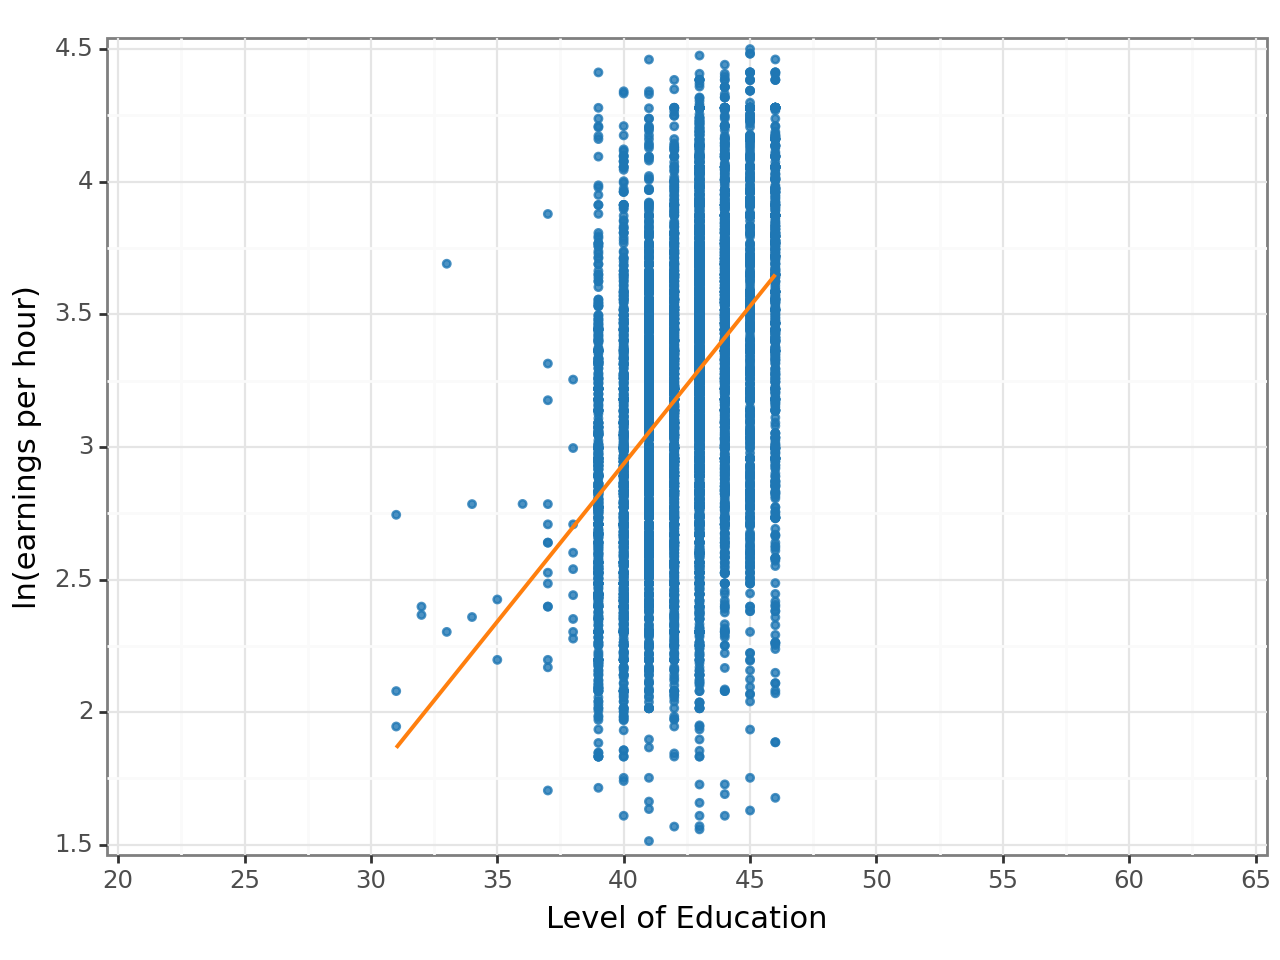

<Figure Size: (640 x 480)>

In [75]:
color = ["#1f77b4", "#ff7f0e"]  # Replace with your desired colors

(
    ggplot(xc, aes(x="grade92", y="lnw"))
    + geom_point(color=color[0], size=1, alpha=0.8, show_legend=False, na_rm=True)
    + geom_smooth(method="lm", colour=color[1], se=False, size=0.8, linetype="solid")
    + coord_cartesian(xlim=(20, 65), ylim=(1.5, 4.5))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(20, 65), breaks=np.arange(20, 66, 5))
    + scale_y_continuous(expand=(0.01, 0.01), limits=(1.5, 4.5), breaks=np.arange(1.5, 4.51, 0.50))
    + labs(x="Level of Education", y="ln(earnings per hour)")
    + theme_bw()
)


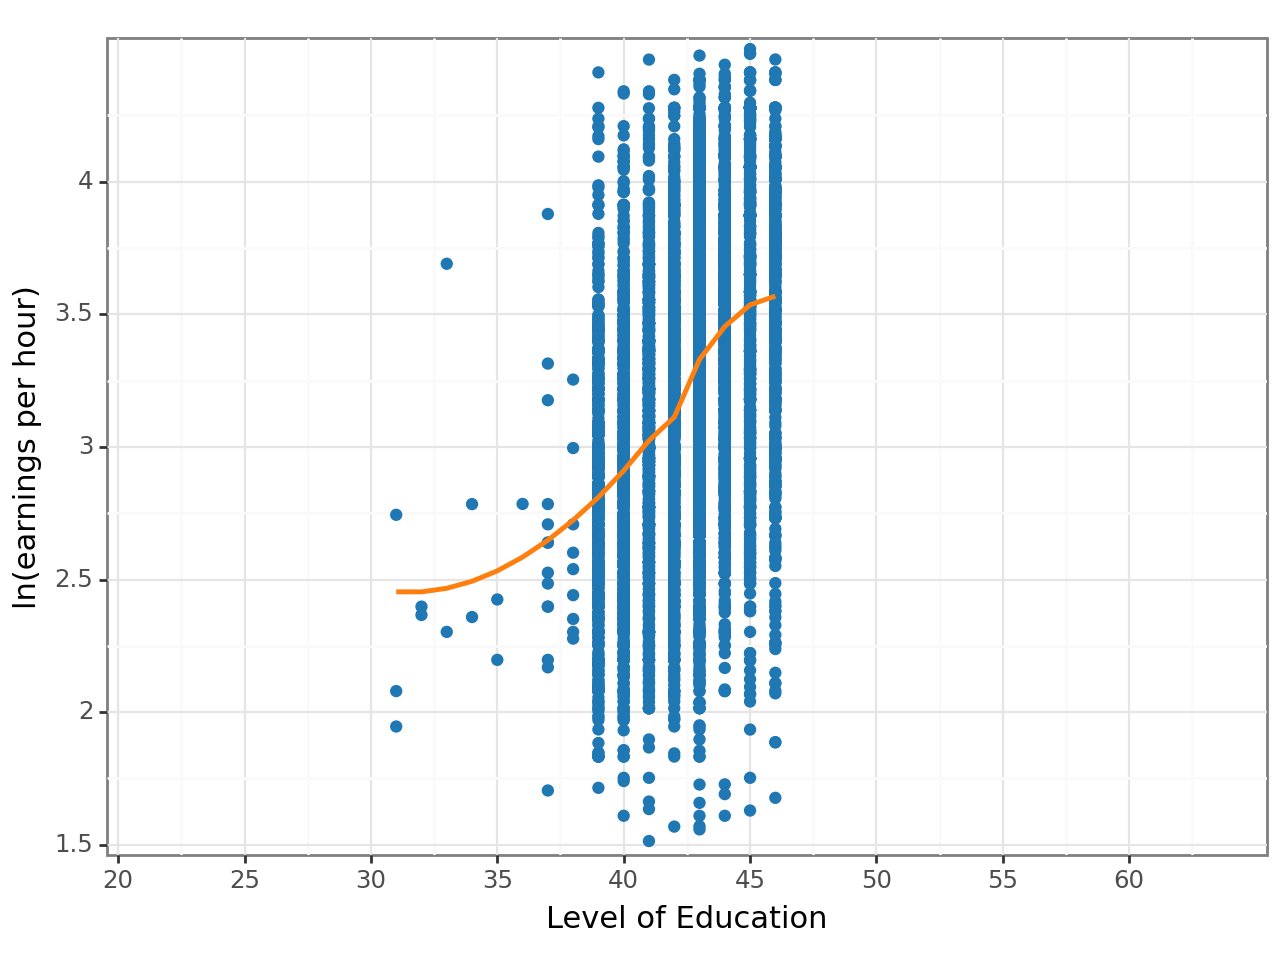

<Figure Size: (640 x 480)>

In [79]:
(
    ggplot(xc, aes(x="grade92", y="lnw"))
    + geom_point(color=color[0])
    + geom_smooth(method="loess", color=color[1], se=False)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(20, 65), breaks=np.arange(20, 65, 5))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(1.5, 4.5), breaks=np.arange(1.5, 4.5, 0.50)
    )
    + labs(x="Level of Education", y="ln(earnings per hour)")
    + theme_bw()
)